# Spitzer-ulens Tutorial Notebook
This notebook aims to demonstrate the usage of the the Spitzer-ulens package for observations with parallax.

In [61]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import pickle
import emcee
import time as ti
from tqdm import tqdm
import os
from multiprocessing import Pool
import corner
from scipy import optimize as opt
import random

from Spitzer_ulens import data_config
from Spitzer_ulens import models
from Spitzer_ulens import PLD

## Configuration and Preparation

This section demonstrates usage of the 'data_config' module.

In [2]:
coords = ('17:47:31.93','-24:31:21.6')
spitzer_data_path = 'data/ob171140/rawdata/'
ogle_data_file = 'data/ob171140/ob171140_ogle.dat'

In [9]:
load_evt_from_file = False
if load_evt_from_file:
    evt = data_config.PLDEventData.from_pickle('ob171140_parallax.pkl')
else:
    # Create a PLDEventData object from our data
    evt = data_config.PLDEventData(spitzer_data_path,coords,recursive=True)
    # Add ground-based observations to our PLDEventData object
    evt.add_OGLE_data(ogle_data_file)
    # Save our PLDEventData object
    evt.save(filepath='ob171140_parallax.pkl',overwrite=True)

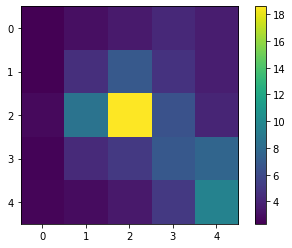

In [10]:
# Plotting an example of a 5-by-5 image
fig,ax = plt.subplots()
im = ax.imshow(evt.img[5][10])
fig.colorbar(im)
plt.show()

Text(0.5, 1.0, 'OGLE Data')

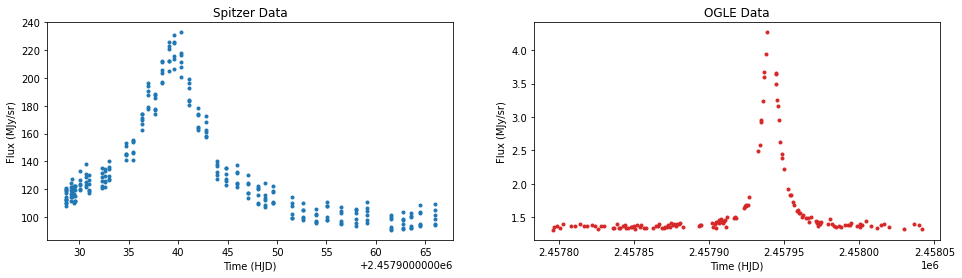

In [19]:
# Get raw photometry, error, and binned error
flux,flux_err,flux_frac,flux_scatter = evt.aperture_photometry()
time = np.array(evt.time)
ind = time<2458000
time = (time[ind]).reshape(6,-1)
flux = flux[ind].reshape(6,-1)
flux_err = flux_err[ind].reshape(6,-1)
flux_frac = flux_frac[ind].reshape(6,-1,5,5)

time_g = np.array(evt.t_g)
ind_g = time_g>2457752
time_g = time_g[ind_g]
flux_g = np.array(evt.flux_g)[ind_g]
flux_err_g = np.array(evt.flux_err_g)[ind_g]

# Plot our raw data
fig,ax = plt.subplots(ncols=2,figsize=(16,4))

ax[0].plot(time.ravel(),flux.ravel(),'C0.')
ax[0].set_xlabel('Time (HJD)')
ax[0].set_ylabel('Flux (MJy/sr)')
ax[0].set_title('Spitzer Data')

ax[1].plot(time_g,flux_g,'C3.')
ax[1].set_xlabel('Time (HJD)')
ax[1].set_ylabel('Flux (MJy/sr)')
ax[1].set_title('OGLE Data')

## Least-Squares Fit

In this section we do a least-squares fit to obtain some better parameter estimates. These will eventually become initial parameters for the MCMC fit. In this section we introduce the 'models' module.

In [57]:
# Make an initial guess for model parameters, which will be used as starting point for the least-squares fit. 
# I got these values from S. Calchi Novati et al 2018 AJ 155 261.

# Single lens model:
t0 = 2457940.7604      # Time of peak magnification
tE = 14.79             # Einstein radius crossing time
u0 = 0.2364            # Impact parameter
fs = 19.7              # Space-based source flux
fb = 82                # Space-based baseline flux
fs_g = 1.127           # Ground-based source flux
fb_g = 0.241           # Ground-based baseline flux
pi_E_N = -0.0739       # Microlens parallax (pi_E) in the N-S direction
pi_E_E = 0.0524        # Microlens parallax (pi_E) in the E-W direction

p0 = np.array([tE,t0,u0,pi_E_N,pi_E_E,fb_g,fs_g,fb,fs])

# Specify some (loose) bounds on our parameters.
bounds = ([0,2457935,-np.inf,-np.inf,-np.inf,0,0,0,0],[140,2457945,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf])

# Some labels
plabels = ['t_E','t_0','u_0','pi_E_N','pi_E_E','f_b_g','f_s_g','f_b','f_s']

In [77]:
# Create our model
model = models.SingleLensParallaxModel(coords,'data/ob171140/spitzer/Spitzer_ephemeris_02.dat')

mag_s,mag_g = model.get_mag(time.ravel(),time_g.ravel(),tE,t0,u0,pi_E_N,pi_E_E)
fbfs_s,cov_s = opt.curve_fit(model.mag2flux,mag_s,flux.ravel(),[fb,fs])
fbfs_g,cov_g = opt.curve_fit(model.mag2flux,mag_g,flux_g,[fb_g,fs_g])
popt_lsq = np.concatenate(([tE,t0,u0,pi_E_N,pi_E_E],fbfs_g,fbfs_s))

timeplot = np.linspace(np.min([np.min(time),np.min(time_g)]),np.max([np.max(time),np.max(time_g)]),1000)
fluxplot_lsq,fluxplot_g_lsq = model(timeplot,timeplot,*popt_lsq)

Text(0.5, 1.0, 'OGLE Data Fit')

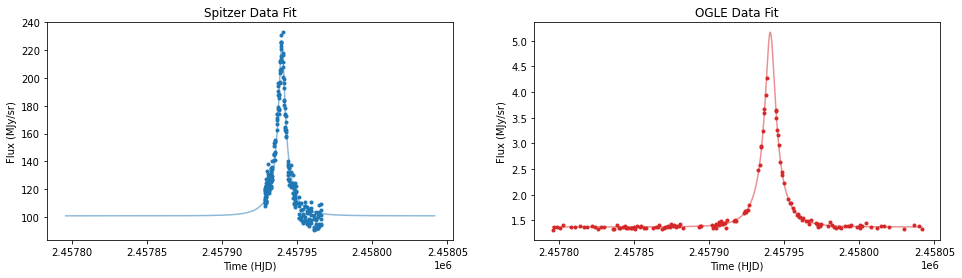

In [22]:
fig,ax = plt.subplots(ncols=2,figsize=(16,4))

ax[0].plot(timeplot,fluxplot_lsq,'C0',alpha=0.5)
ax[0].plot(time.ravel(),flux.ravel(),'C0.')
ax[0].set_xlabel('Time (HJD)')
ax[0].set_ylabel('Flux (MJy/sr)')
ax[0].set_title('Spitzer Data Fit')

ax[1].plot(timeplot,fluxplot_g_lsq,'C3',alpha=0.5)
ax[1].plot(time_g,flux_g,'C3.')
ax[1].set_xlabel('Time (HJD)')
ax[1].set_ylabel('Flux (MJy/sr)')
ax[1].set_title('OGLE Data Fit')

## Solving PLD Coefficients Analytically

In [23]:
# Solve for PLD coefficients analytically (X)
astro, pld_coeffs, A, C, flu_g = PLD.analytic_solution(time,flux,flux_err,flux_frac,popt_lsq,model,time_g)
# Get detector model and divide it out to get new best-fit
fit,sys,corr,resi = PLD.get_bestfit(pld_coeffs, flux, flux_frac, astro, A)

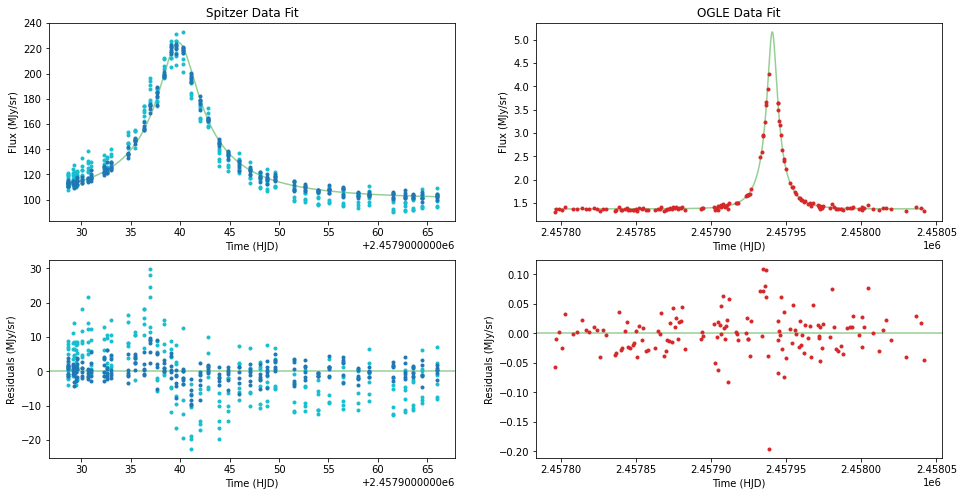

In [85]:
def plot_analytic_sol(model,time,time_g,popt,astro,flux,corr,flux_g):
    timeplot_s = np.linspace(time.min(),time.max(),1000)
    timeplot_g = np.linspace(time_g.min(),time_g.max(),1000)
    fig,ax = plt.subplots(ncols=2,nrows=2,figsize=(16,8))

    ax[0,0].plot(timeplot_s,model(timeplot_s,timeplot_s,*popt)[0],'C2',alpha=0.5)
    ax[0,0].plot(time.ravel(),flux.ravel(),'C9.')
    ax[0,0].plot(time.ravel(),corr.ravel(),'C0.')
    ax[0,0].set_xlabel('Time (HJD)')
    ax[0,0].set_ylabel('Flux (MJy/sr)')
    ax[0,0].set_title('Spitzer Data Fit')

    ax[1,0].axhline(c='C2',alpha=0.5)
    ax[1,0].plot(time.ravel(),flux.ravel()-astro.ravel(),'C9.')
    ax[1,0].plot(time.ravel(),corr.ravel()-astro.ravel(),'C0.')
    ax[1,0].set_xlabel('Time (HJD)')
    ax[1,0].set_ylabel('Residuals (MJy/sr)')

    ax[0,1].plot(timeplot,model(timeplot_g,timeplot_g,*popt)[1],'C2',alpha=0.5)
    ax[0,1].plot(time_g,flux_g,'C3.')
    #ax[0,1].plot(time_g,flu_g,'C3.')
    ax[0,1].set_xlabel('Time (HJD)')
    ax[0,1].set_ylabel('Flux (MJy/sr)')
    ax[0,1].set_title('OGLE Data Fit')

    ax[1,1].axhline(c='C2',alpha=0.5)
    ax[1,1].plot(time_g,flux_g-model(time_g,time_g,*popt)[1],'C3.')
    #ax[1,1].plot(time_g,flu_g-model(time_g,time_g,*popt)[1],'C3.')
    ax[1,1].set_xlabel('Time (HJD)')
    ax[1,1].set_ylabel('Residuals (MJy/sr)')
plot_analytic_sol(model,time,time_g,popt_lsq,astro,flux,corr,flux_g)

# MCMC Fit for PLD Parameters

In this section we run a Markov Chain Monte-Carlo (MCMC) fit to our flux data. This will explore parameter space to optimize the log-likelihood for our model to fit our data. We use the emcee package (https://github.com/dfm/emcee) to do our fit. The log-likelihood function we use is a method of the SingleLensParallaxModel class, as detailed in the 'Spitzer_ulens.models' module.

In [26]:
def run_mcmc(sampler,pos0,nsteps,visual=True,label=''):
    if visual:
        tic = ti.time()
        print('Running MCMC '+label+'...')
        
        # Using tqdm package to generate progress bars
        for pos, prob, state in tqdm(sampler.sample(pos0, iterations=nsteps),total=nsteps):
            pass

        print("Mean burn-in acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
        toc = ti.time()
        print('MCMC runtime = %.2f min\n' % ((toc-tic)/60.))
        return pos,prob,state
    else:
        pos,prob,state = sampler.run_mcmc(pos0,nsteps)
        return pos,prob,state

In [27]:
def get_MCMC_results(pos_chain,lnp_chain):
    _,_,npars = pos_chain.shape
    posit = pos_chain.reshape(-1,npars)

    # Get the percentile
    percs = np.percentile(posit, [16, 50, 84],axis=0)
    (MCMC_Results) = np.array(list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*percs))))

    popt = MCMC_Results[:,0]
    std_hi = MCMC_Results[:,1]
    std_lo = MCMC_Results[:,2]

    # Get most probable params
    probs = lnp_chain.flatten()
    pmax = posit[np.argmax(probs)]
    
    return popt,pmax,std_hi,std_lo

In [41]:
load_chain_from_file = True
savepath = 'out/1lens_par'

if load_chain_from_file:
    pos_chain = np.load(os.path.join(savepath,'samplerchain.npy'))
    lnp_chain = np.load(os.path.join(savepath,'samplerlnpro.npy'))
else:
    # 'l0' are our weight factors, which are used to specify the relative importances of parts of 
    # our log-likelihood function, namely the space-based and ground-based parts. Our MCMC will 
    # fit for these as well. See the 'SingleLensParallaxModel.lnlike' function in the models module
    # for more details.
    l0 = [1,1]
    p0 = np.concatenate((popt_lsq,l0))
    
    nwalkers = 100
    nburnin = 300
    nprod = 1000
    
    # Generate the MCMC sampler with 100 walkers, our log-probability function, and our data. We
    # use pool from the multiprocessing package to parallelize the process.
    sampler = emcee.EnsembleSampler(nwalkers, len(p0), model.lnprob, a = 2, pool=Pool(),
                                    args=(bounds,time,time_g,flux,flux_err,flux_frac,
                                          flux_scatter,flux_g,flux_err_g))
    
    # Initialize the initial parameter positions for each walker by adding a random offset. Starting
    # our walkers in different positions allows us to explore more parameter space.
    pos0 = [p0*(1+1e-5*np.random.randn(sampler.ndim))+1e-5*np.abs(np.random.randn(sampler.ndim)) 
            for i in range(sampler.nwalkers)]
    
    # Run the first MCMC burn-in.
    pos1,prob,state = run_mcmc(sampler,pos0,nburnin,label='first burn-in')
    sampler.reset()

    #Run the MCMC from best spot from last time, and do another burn-in to get the walkers spread out.
    pos2 = pos1[np.argmax(prob)]
    
    # Slightly change position of walkers to prevent them from taking the same path
    pos2 = [pos2*(1+1e-6*np.random.randn(sampler.ndim))+1e-6*np.abs(np.random.randn(sampler.ndim)) 
            for i in range(sampler.nwalkers)]
    
    # Run the second burn-in
    pos2, prob, state = run_mcmc(sampler,pos2,nburnin,label='second burn-in')
    sampler.reset()
    
    #Run the final production run that will be saved
    pos_final, prob, state = run_mcmc(sampler,pos2,nprod,label='production')

    pos_chain = sampler.chain
    lnp_chain = sampler.lnprobability
    
    np.save(os.path.join(savepath,'samplerchain.npy'),pos_chain)
    np.save(os.path.join(savepath,'samplerlnpro.npy'),lnp_chain)
    
# Get results from chain
popt_mcmc,pmax,std_hi,std_lo = get_MCMC_results(pos_chain,lnp_chain)

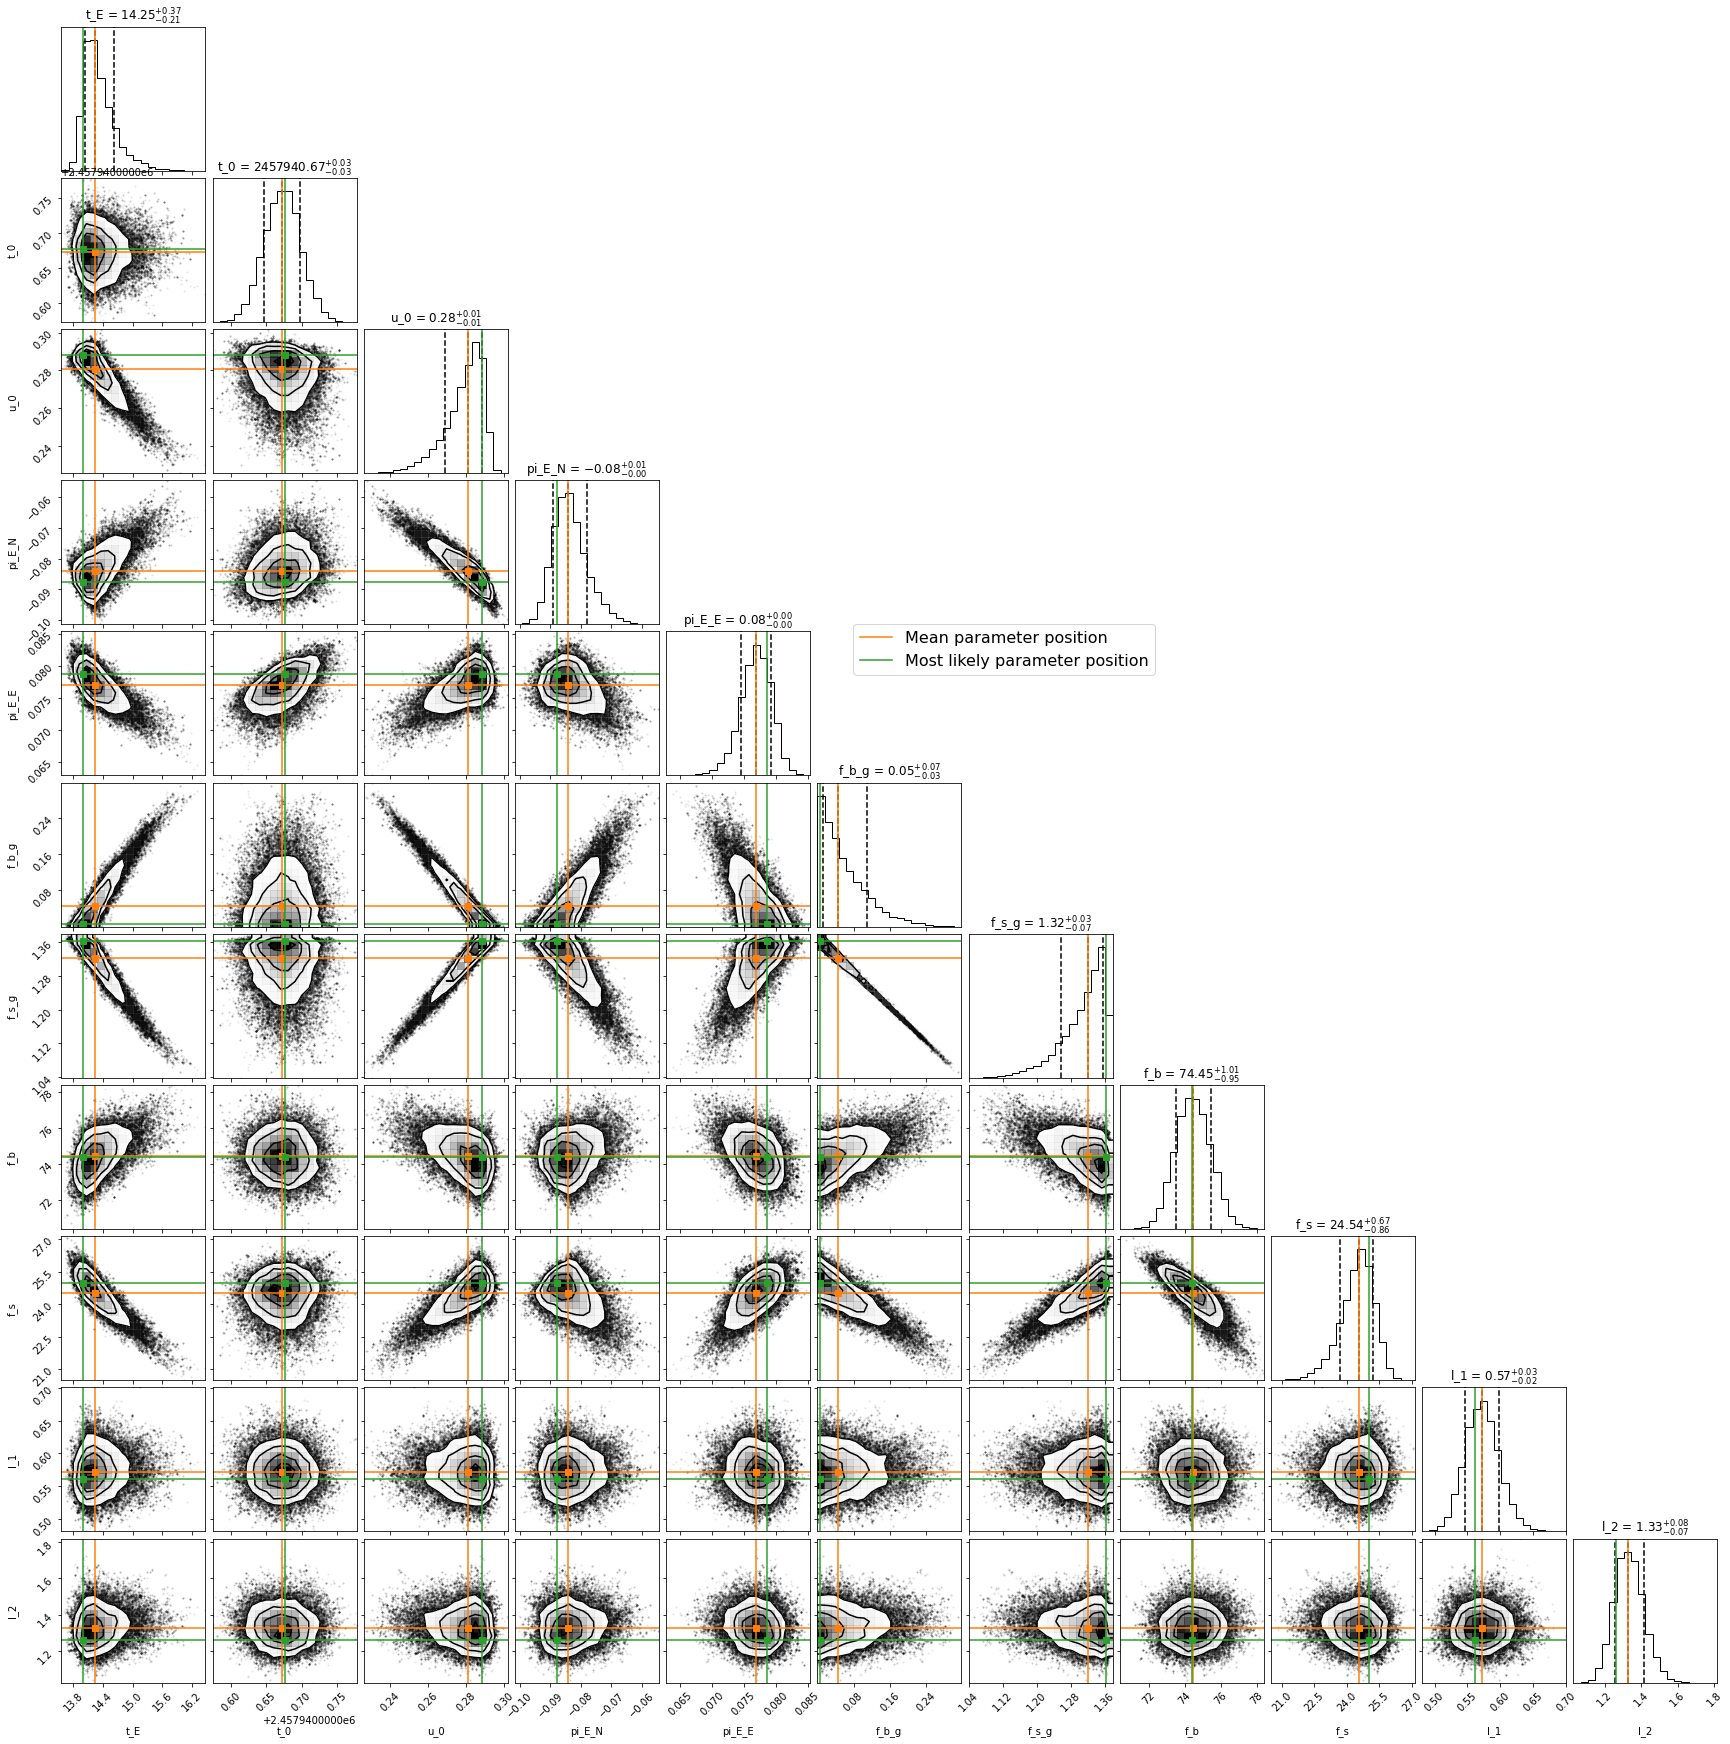

In [58]:
# Create corner plots to check for convergence
# 1d array of samples
samples = pos_chain.reshape((-1, len(popt_mcmc)))
plabels += ['l_1','l_2']

# corner plot
fig = corner.corner(samples, quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True, plot_datapoints=True, 
                    title_kwargs={"fontsize": 12},labels=plabels)

corner.overplot_lines(fig, popt_mcmc, color="C1", label='Mean parameter position')
corner.overplot_points(fig, popt_mcmc[None], marker="s", color="C1")
corner.overplot_lines(fig, pmax, color="C2", label='Most likely parameter position')
corner.overplot_points(fig, pmax[None], marker="s", color="C2")

plt.legend(loc=(-5,7),fontsize=16)

In [43]:
# Re-run MCMC if it does not look converged. This cell can be run repeatedly.
rerun_mcmc = False
if rerun_mcmc:
    
    sampler = emcee.EnsembleSampler(nwalkers, len(p0), model.lnprob, a = 2, pool=Pool(),
                                    args=(bounds,time,time_g,flux,flux_err,flux_frac,
                                          flux_scatter,flux_g,flux_err_g))
    pos0 = pos_chain[-1]

    pos_final,prob_final,state_final = mcmc.run_mcmc(sampler,pos0,3000,label='production')

    pos_chain = sampler.chain
    lnp_chain = sampler.lnprobability
    
    popt_mcmc,pmax,std_hi,std_lo = get_MCMC_results(pos_chain,lnp_chain)

In [87]:
# Reporting best-fit parameters
def pretty_print(popt,pmax,std_hi,std_lo,labels):
    tab = np.transpose([labels,popt,pmax,std_hi,std_lo])
    print('\t%s\t\t%s\t%s\t\t%s'%('Mean Parameter','Most Likely Parameter',r'Upper 1 sigma',r'Lower 1 sigma'))
    for row in tab:
        print('%s\t%s\t%s\t%s\t%s'%(row[0],row[1],row[2],row[3],row[4]))
pretty_print(popt_mcmc,pmax,std_hi,std_lo,plabels)

	Mean Parameter		Most Likely Parameter	Upper 1 sigma		Lower 1 sigma
t_E	14.249177352993694	14.004041910403163	0.3719906753673321	0.21075653132261074
t_0	2457940.6725666574	2457940.676662645	0.025468579027801752	0.026428445242345333
u_0	0.2809935465090702	0.28814066322113757	0.007040383185911325	0.01247783064210295
pi_E_N	-0.08402036937032095	-0.08761677950977768	0.006242812453768634	0.004873339144695177
pi_E_E	0.0769689590604475	0.07866329383699663	0.0022848253839238414	0.0024695058854043994
f_b_g	0.04575147103613407	0.006093868781938683	0.06508746474805088	0.033981529666902086
f_s_g	1.3216651197337481	1.3625279958160204	0.03437718257393341	0.06558270045428083
f_b	74.44681037140248	74.40673151711829	1.0089869809939245	0.9534234578130594
f_s	24.537313744232367	25.000373095365617	0.6658184688710236	0.8604393629886076
l_1	0.5718277718814444	0.5614124238088128	0.02636595610888004	0.024913711121790305
l_2	1.3297100722664965	1.2633248744013263	0.08324311841262655	0.07477166382268163


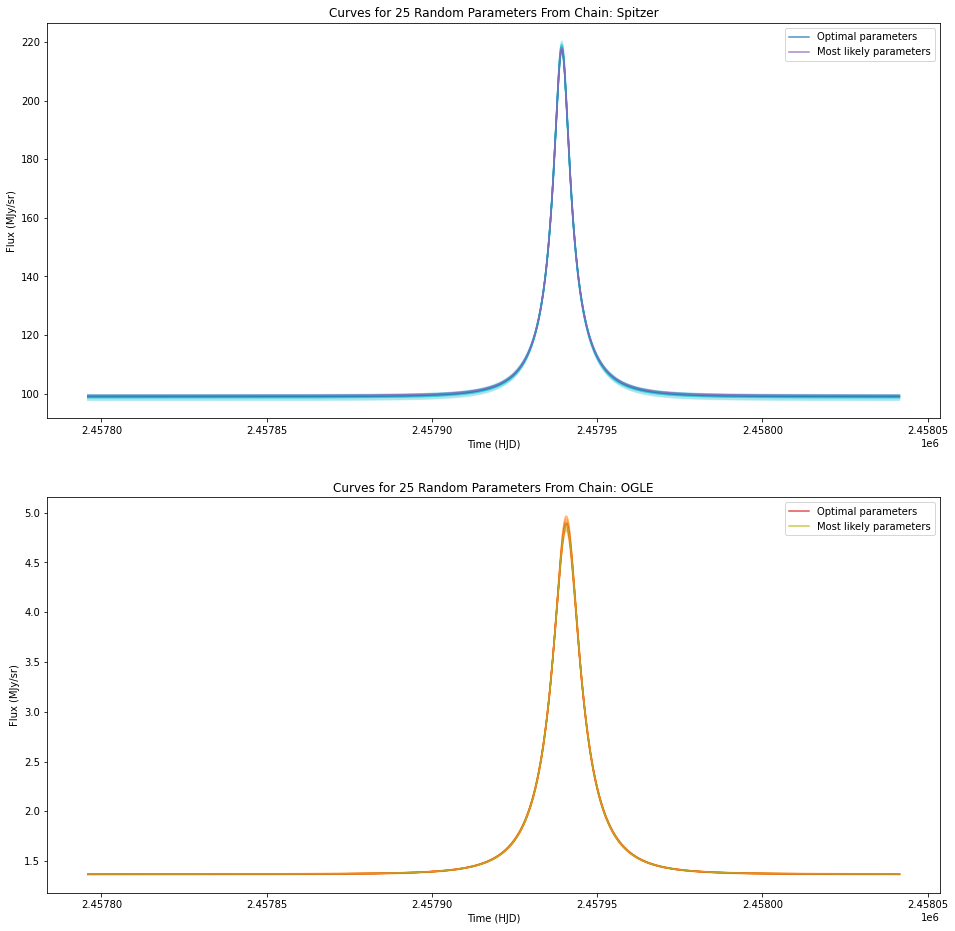

In [82]:
# Plotting a bunch of random curves to see the scatter
def plot_random_curves(pos_chain,model,timeplot,popt=None,pmax=None,ncurves=1,seed=None,figsize=(16,16)):
    fig,ax = plt.subplots(nrows=2,figsize=figsize)
    nwalkers,nsteps,npars = np.shape(pos_chain)
    chain = pos_chain.reshape(nwalkers*nsteps,-1)
    for i in range(ncurves):
        pars = random.choice(chain)
        flu_s,flu_g = model(timeplot,timeplot,*pars)
        ax[0].plot(timeplot,flu_s,alpha=0.2,c='C9')
        ax[1].plot(timeplot,flu_g,alpha=0.2,c='C1')
    ax[0].set_title('Curves for %i Random Parameters From Chain: Spitzer'%ncurves)
    ax[0].set_xlabel('Time (HJD)')
    ax[0].set_ylabel('Flux (MJy/sr)')
    ax[1].set_title('Curves for %i Random Parameters From Chain: OGLE'%ncurves)
    ax[1].set_xlabel('Time (HJD)')
    ax[1].set_ylabel('Flux (MJy/sr)')
    if popt is not None:
        flu_s,flu_g = model(timeplot,timeplot,*popt)
        ax[0].plot(timeplot,flu_s,alpha=0.8,c='C0',label='Optimal parameters')
        ax[1].plot(timeplot,flu_g,alpha=0.8,c='C3',label='Optimal parameters')
    if pmax is not None:
        flu_s,flu_g = model(timeplot,timeplot,*pmax)
        ax[0].plot(timeplot,flu_s,alpha=0.8,c='C4',label='Most likely parameters')
        ax[1].plot(timeplot,flu_g,alpha=0.8,c='C8',label='Most likely parameters')
    ax[0].legend()
    ax[1].legend()
        
plot_random_curves(pos_chain[:,:,:-2],model,timeplot,popt=popt_mcmc[:-2],pmax=pmax[:-2],ncurves=25,figsize=(16,16))

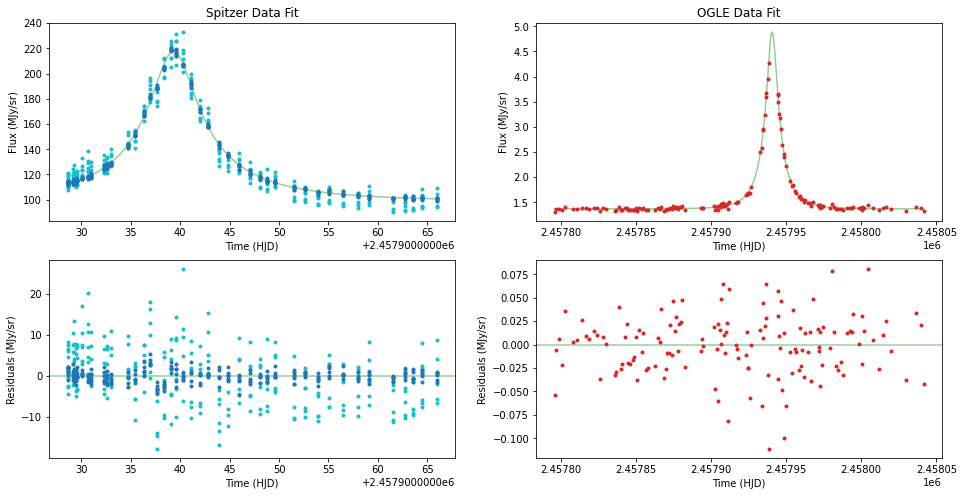

In [89]:
# Final analytic solution for corrected data
astro, pld_coeffs, A, C, flu_g = PLD.analytic_solution(time,flux,flux_err,flux_frac,popt_mcmc[:-2],model,time_g)
# Get detector model and divide it out to get new best-fit
fit,sys,corr,resi = PLD.get_bestfit(pld_coeffs, flux, flux_frac, astro, A)
plot_analytic_sol(model,time,time_g,popt_mcmc[:-2],astro,flux,corr,flux_g)